# Brick Builder develop guideline

#### Omar Ruiz

In [29]:
import pandas as pd

In [31]:
df = pd.read_csv('/home/omar/myproj/SmartBricks/legoKeys.cvs', sep='\t')

In [25]:
from brickcreator import SmartBricks
import shutil
from pathlib import Path
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
outdir = Path('/home/omar/myproj/myface')
if outdir.exists() & outdir.is_dir():
    shutil.rmtree(outdir)

In [27]:
%time SB = SmartBricks(imgpath='/home/omar/Desktop/me_test.jpeg', Ncolors=4, lowsize=32, outdir=outdir)

(87296, 3)
(1344, 3)
CPU times: user 3.83 s, sys: 9.4 ms, total: 3.84 s
Wall time: 2.86 s


<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

2x2 	 178
2x1 	 203
1x1 	 215
Total run time: 8.276420 sec
CPU times: user 6.02 s, sys: 113 ms, total: 6.13 s
Wall time: 8.28 s


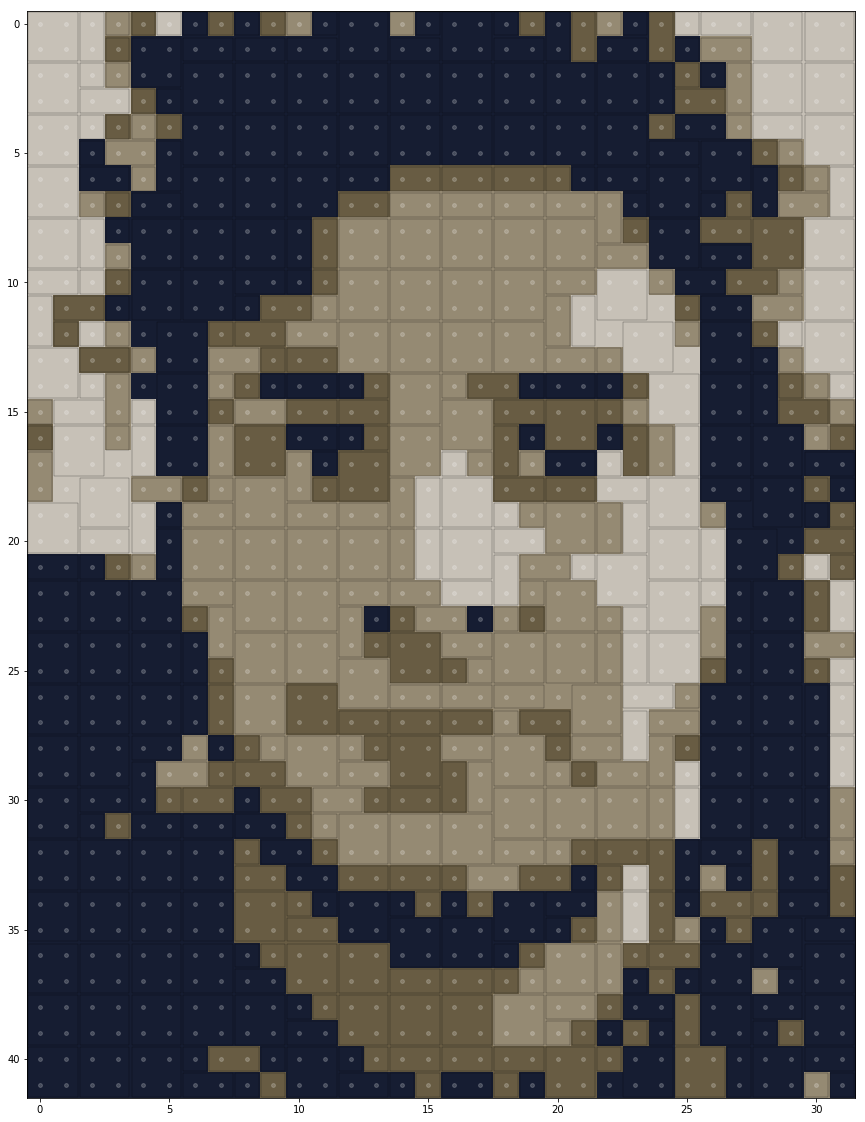

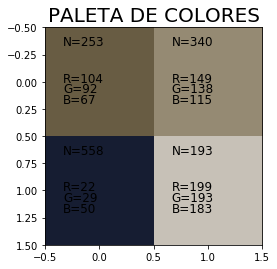

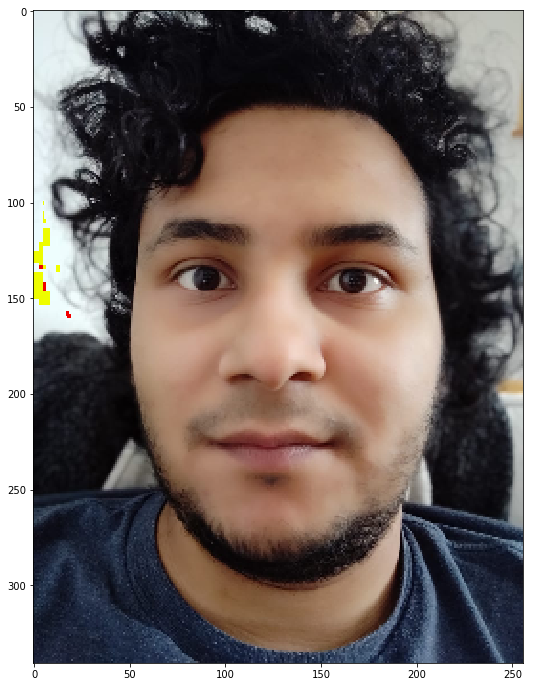

In [28]:
%time SB.saveProj()

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from sklearn import cluster, datasets
from sklearn.cluster  import KMeans
from sklearn.datasets import load_digits            
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import transform,io
from sklearn.neighbors import NearestNeighbors
import pandas as pd

from scipy.cluster.vq import kmeans

from IPython.display  import Image as display_image
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def imgFlat(img):
    
    img_flat = sp.reshape(img, (img.shape[0]*img.shape[1],img.shape[2])).astype(float)
    return img_flat

def resize(img, low=54):
    
    #plt.figure(figsize=(8,8))
    h, w = img.shape[0:2]
    r = h/w
    if w < h: w, h = low, np.floor(low*r )
    else: h, w = low, np.floor(low/r)
    
    size = (h, w)
    img0 = transform.resize(img, size)
    
    #Recover normal RGB values
    img_flat = sp.reshape(img0, (img0.shape[0]*img0.shape[1], img0.shape[2])).astype(float)
    new_img = np.ones(img_flat.shape, dtype='float64')
    for i in [0,1,2]:
        new_img[:,i] = img_flat[:,i]*256
    
    new_img = np.array(new_img, dtype=('uint8'))
    new_img = sp.reshape(new_img.flatten(), (img0.shape[0], img0.shape[1], img0.shape[2]))
    
    return new_img

def kmeans(img, N=8):
    
    img0 = img[:, :, :3]
    img_flat = sp.reshape(img0, (img0.shape[0]*img0.shape[1],img0.shape[2])).astype(float)
    
    # K-means in sklearn.
    clf = KMeans(n_clusters = N, init='k-means++')
    clf.fit(img_flat.astype(float)) 
    indices= clf.predict(img_flat)
    
    kmeans_img = sp.reshape(indices, (img0.shape[0], img0.shape[1]))
    
    return kmeans_img, indices
    
def toBrick(img, plots=False, N=8):
    
    #img0 = img[:, :, :3]
    img0 = img
    img_flat = sp.reshape(img0, (img0.shape[0]*img0.shape[1],img0.shape[2])).astype(float)
    
    kmeans_img, indices = kmeans(img, N=N)
    
    #
    plt.figure(figsize=(10, 12))
    bins = np.linspace(0, 256, 40)
    indices_new = np.ones(img_flat.shape, dtype='float64')

    for num, band in enumerate(['R', 'G', 'B']):
        for i in list(set(indices)):
    
            mask = np.where((indices == i))[0]
            #print(i, len(mask))
            if plots:
                plt.subplot(3, 1, num+1)
                plt.title(r'PIXEL ENTRY %s' %(band))
                plt.hist(img_flat[:,num][mask], bins=bins, histtype='step', lw=2, label=r'cluster %i' %(i))
                plt.legend()
            #
            indices_new[:,num][mask] = np.median(img_flat[:,num][mask])
        
            #print(band, i, set(indices_new[:,num][mask]))

    indices_new = np.array(indices_new, dtype=('uint8'))
    print(indices_new.shape)
    new_img = sp.reshape(indices_new.flatten(), (img0.shape[0], img0.shape[1], img0.shape[2]))
    
    return new_img, indices_new

def palette(img):
    
    img_flat = sp.reshape(img, (img.shape[0]*img.shape[1],img.shape[2])).astype(float)
    
    Nlist = list(set(img_flat[:,0]))
    N = len(Nlist)
    print(N)
    
    fig = plt.figure(figsize=(N, 4))
    
    palette = np.empty((len(Nlist), 3), dtype='uint8')
    for num, i in enumerate(Nlist):

        mask = np.where((img_flat[:,0] == i))
        palette[num,:] = (img_flat[mask][0])
    
    palette = sp.reshape(palette.flatten(), (2, np.int(N/2), img.shape[2]))
    plt.title(r'PALETA DE COLORES', size=20)
    plt.imshow(palette)
    
    delta = 1/3
    for i in [0, 1]:
        for j in range(np.int(N/2)):
            Ncolori = np.sum(img_flat[:,0] == palette[i][j][0])
            #plt.text(j-delta, i, r'RGB=(%i, %i, %i)' %(palette[i][j][0], palette[i][j][1], palette[i][j][2]), size=12)
            k = 0
            for num, band in enumerate(['R', 'G', 'B']):
                plt.text(j-delta, i+k, r'%s=%i' %(band, palette[i][j][num]), size=12)
                k += 0.1
            plt.text(j-delta, i-delta, r'N=%i' %(Ncolori), size=12)

    fig.savefig('paleta_colores_test.jpeg', bbox_inches = 'tight', pad_inches = 0)
    
    return palette


## 1. Image Segmentation with k-means

In this first section, we introduce the k-means algorithm - the simplest clustering algorithm and its implementation in sklearn. As a simple application, we then show how k-means clustering can be used to segment an image by colour. By grouping similar (r,g,b) values together we should be able to extract different parts of the picture. We begin by loading an image below:

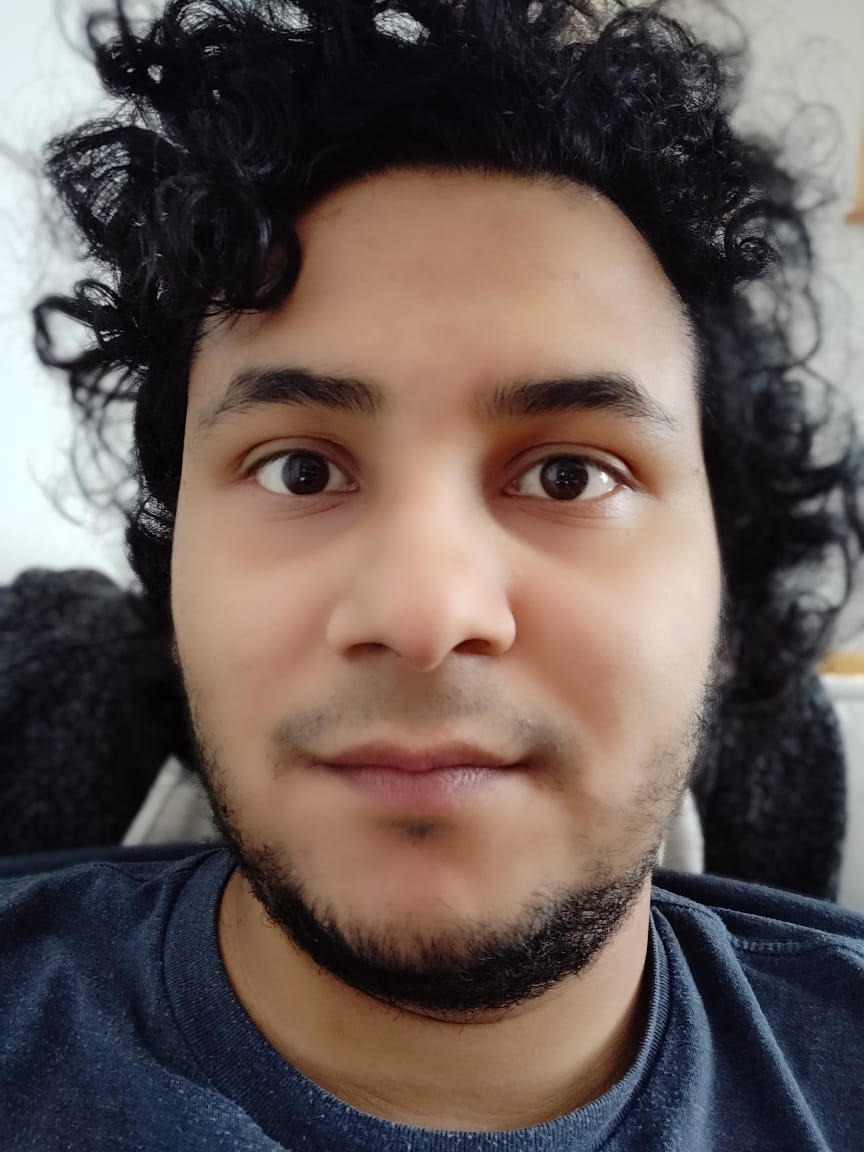

In [3]:
#imgpath = '/home/omar/Pictures/bulldog.jpg'
imgpath = '/home/omar/Desktop/me_test.jpeg'
img = imageio.imread(imgpath)
display_image(filename=imgpath, width = 300, height = 300)

The image above consists of (314 x 500) pixels. Each entry in the img array above encodes the colour values for each pixel. There are four values - the three primary (rgb) colours as well as an alpha (opacity) value. The opacity value is not relevant here so we'll discard it. We need to reshape the img array above in other to get it into a form that is suitable for the sklearn machine learning algorithms. These generally take **two dimensional arrays** where **columns** are regarded as **features** and **rows** as **samples**. We'll therefore reshape img into a three column array (r,g,b) with as many rows as there are pixels

In [4]:
img.shape

(1152, 864, 3)

The algorithm uses two parameters as inputs:

*  `Ncolors`: Number of colors to break the image.
* `lowsize`: Minimum size (width or height) of image in pixels/bricks.

If the image size is bigger than 512 pixels ($pix$), it's downsized to $256$ $pix$.


In [5]:
Ncolors = 4
lowsize = 48

#height & width of image
h,w = img.shape[0:2]
if img.shape[2] >= 4: img = img[:, :, 0:3]
#image is bigger than 512 pix?
if (h > 512) or (w > 512): img = resize(img=img, low=256)

print('New image size:',img.shape)

New image size: (341, 256, 3)


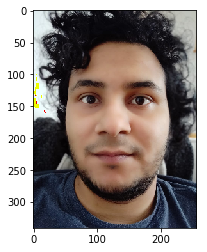

In [6]:
plt.imshow(img)

In [48]:
#img = resize(img=img, low=128)

Next we use K-means to break image in $N$ primary colors defined by `Ncolors`.

***K-means clustering in sklearn***  
Notice the similarity in syntax to the classifiers used in supervised learning. kmeans requires the number of clusters as input. The fit method calculates the centroids based on the input data, whilst the predict method assigns cluster membership to each point. Notice that once fitted, the predict method is able to take new data - so you can assign cluster membership to new points.

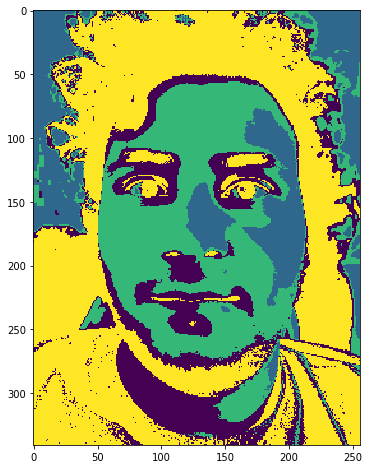

In [7]:
kmeans_img, indices = kmeans(img=img, N=Ncolors)
plt.figure(figsize=(8, 8))
plt.imshow(kmeans_img)

Then we recover the original image colors by getting the mean of the `Ncolors` clusters.

(87296, 3)


<Figure size 720x864 with 0 Axes>

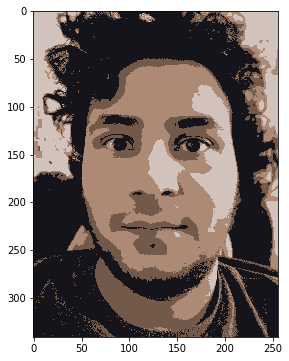

In [8]:
new_img, indices_new = toBrick(img=img, N=Ncolors)
plt.figure(figsize=(6, 6))
plt.imshow(new_img)

Then we translate the new image with size $256$ to the desired pix/brick size with a minimum of `lowsize` in either width or height. However, by doing this we loss the `Ncolors` and new downsized image have more than `Ncolors`. To solve this, we implement the `K-means` algorith again and re-recover the original colors with same approximation.

Below we have the code that does the three mention steeps.

Note that could have go staright and downsize the image first instead of implement the `k-means` and recover colors on original image but this will give us a poor color definition as the `K-means` is applied on the downsize image. This is why we apply `K-means` twice, one to get the faithfulest representation of the original image colors and the second to recover the the colors.

(3024, 3)


<Figure size 720x864 with 0 Axes>

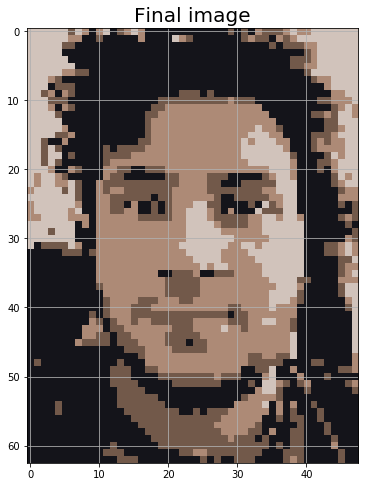

In [9]:
new_img_red = resize(img=new_img, low=lowsize)
kmeans_img2, indices2 = kmeans(img=new_img_red, N=Ncolors)
new_img_red2, indices_new2 = toBrick(img=new_img_red, N=Ncolors)

plt.figure(figsize=(8, 8))
plt.title(r'Final image', size=20)
plt.imshow(new_img_red2)
#plt.xticks(np.arange(0, lowsize))
#plt.yticks(np.arange(0, lowsize))
plt.grid()


To check the distribution of colors in the $R$, $G$, $B$ syntax, run `toBrick` with `plots=True`.

(3024, 3)


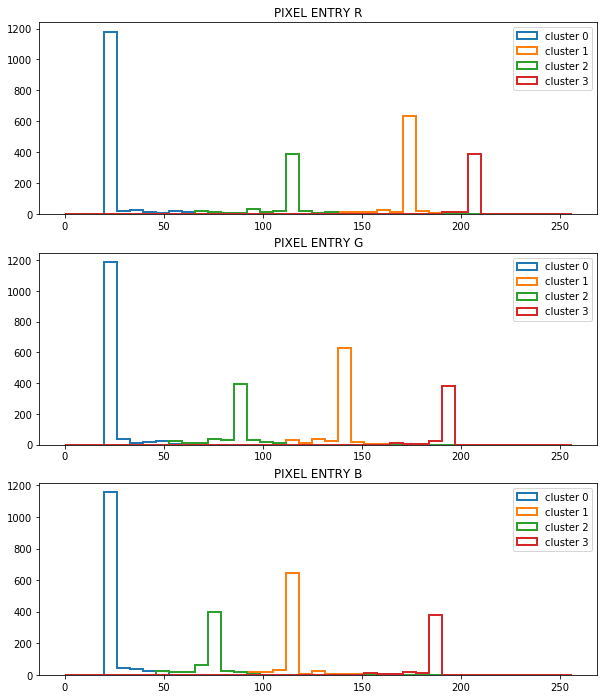

In [10]:
new_img_red2, indices_new2 = toBrick(img=new_img_red, plots=True, N=Ncolors)

The color palette can be displayed with below code.

In [11]:
new_img_red2.shape

(63, 48, 3)

4


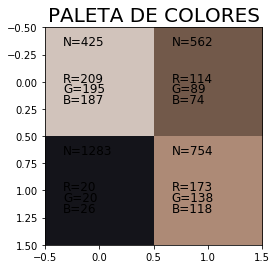

In [12]:
#Original color palette
paletteO = palette(new_img_red2)

In [13]:
h, w = new_img_red2.shape[0:2]

## 2. Aproximate to Lego colors

In [16]:
def toLegoColors(img):
    
    index = 0
    df = pd.read_csv('legoKeys.cvs', sep='\t')
    
    legoColors = np.empty((len(df), 3), dtype='float64')
    for i in range(len(df)):
        legoColors[i] = [df['R'][i], df['G'][i], df['B'][i]]
    
    imgflat = imgFlat(img)
    
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(legoColors)
    distances, indices = nbrs.kneighbors(imgflat)
    
    img_lego = legoColors[indices[:,index]]
    img_lego = np.array(img_lego, dtype=('uint8'))
    img_lego = sp.reshape(img_lego, (img.shape[0], img.shape[1], img.shape[2]))
    
    return img_lego
    

In [17]:
img_lego = toLegoColors(new_img_red2)

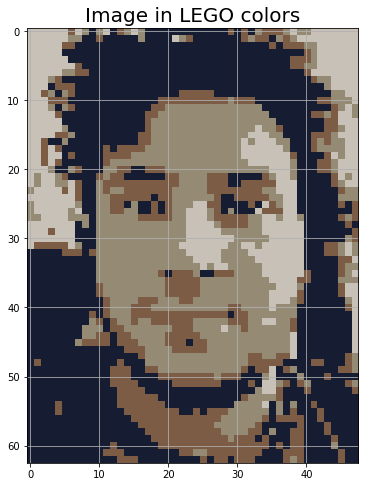

In [18]:
plt.figure(figsize=(8, 8))
plt.title(r'Image in LEGO colors', size=20)
plt.imshow(img_lego)
#plt.xticks(np.arange(0, lowsize))
#plt.yticks(np.arange(0, lowsize))
plt.grid()

New color pallete

4


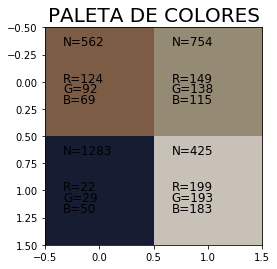

In [19]:
paletteLego = palette(img_lego)

## 3. Brick-type finder

In second section we implement the algorith to fin the $3$ kind of bricks the mosaic allows. This are bricks with sizes:

* $1 \times 1$
* $1 \times 2$
* $2 \times 2$


In [20]:

def brickGrid(img, fig, ax):
    
    h, w = img.shape[0:2]
    
    #Lego-like bricks style
    brickGrid = []
    for i in range(w):
        for j in range(h):
            brickGrid.append([i, j])
    brickGrid = np.array(brickGrid).T
    
    plt.scatter(brickGrid[0], brickGrid[1], s=15, c='w', alpha=0.2)
    plt.xticks(np.arange(0, w, 5))
    plt.yticks(np.arange(0, h, 5))
    
    return brickGrid

def tractor2x2(img, kind=None):
    
    img_test = np.zeros((img.shape[0:2]), dtype=('int'))
    h, w = img.shape[0:2]

    binAi = np.arange(0, w+1, 2)
    binAj = np.arange(0, h+1, 2)
    binBi = np.arange(1, w, 2)
    binBj = np.arange(1, h, 2)

    if kind == 'A': bini, binj = binAj, binAi
    elif kind == 'B': bini, binj = binBj, binAi
    elif kind == 'C': bini, binj = binAj, binBi
    elif kind == 'D': bini, binj = binBj, binBi
        
    k = 1
    for i in range(len(bini[:-1])):
        for j in range(len(binj[:-1])):
        
            img_flat = imgFlat(img[bini[i]:bini[i+1],binj[j]:binj[j+1]])
            if np.all(img_flat[:,0] == img_flat[:,0][0]):
                img_test[bini[i]:bini[i+1],binj[j]:binj[j+1]] = k
                k += 1
                
    return img_test

def tractor2x1(img, kind=None):
    
    img_test = np.zeros((img.shape[0:2]), dtype=('int'))
    h, w = img.shape[0:2]

    binAi = np.arange(0, w+1, 2)
    binAj = np.arange(0, h+1, 1)
    binBi = np.arange(1, w, 2)
    binCi = np.arange(0, h+1, 2)
    binCj = np.arange(0, w+1, 1)
    binDi = np.arange(1, h, 2)

    if kind == 'A': bini, binj = binAj, binAi
    elif kind == 'B': bini, binj = binAj, binBi 
    elif kind == 'C': bini, binj = binCi, binCj
    elif kind == 'D': bini, binj = binDi, binCj

    k = 1
    for i in range(len(bini[:-1])):
        for j in range(len(binj[:-1])):
        
            img_flat = imgFlat(img[bini[i]:bini[i+1],binj[j]:binj[j+1]])
            if np.all(img_flat[:,0] == img_flat[:,0][0]):
                img_test[bini[i]:bini[i+1],binj[j]:binj[j+1]] = k
                k += 1
                
    return img_test

def tractor1x1(img, kind=None):
    
    img_test = np.zeros((img.shape[0:2]), dtype=('int'))
    h, w = img.shape[0:2]

    binAi = np.arange(0, h+1, 1)
    binAj = np.arange(0, w+1, 1)

    if kind == 'A': bini, binj = binAi, binAj
    elif kind == 'B': bini, binj = binAi, binAj
    elif kind == 'C': bini, binj = binAi, binAj
    elif kind == 'D': bini, binj = binAi, binAj

    k = 1
    for i in range(len(bini[:-1])):
        for j in range(len(binj[:-1])):
        
            img_flat = imgFlat(img[bini[i]:bini[i+1],binj[j]:binj[j+1]])
            if np.all(img_flat[:,0] == img_flat[:,0][0]):
                img_test[bini[i]:bini[i+1],binj[j]:binj[j+1]] = k
                k += 1
                
    return img_test

def brickFinder(img, brick=None):
    
    from random import shuffle
    
    img_new = np.zeros((img.shape[0]*img.shape[1], 4), dtype=('int'))

    for num, kind in enumerate(['A', 'B', 'C', 'D']):
        if brick == '2x2':
            #find all possible 2x2 bricks
            img_test = tractor2x2(img=img, kind=kind)
        elif brick == '2x1':
            img_test = tractor2x1(img=img, kind=kind)
        elif brick == '1x1':
            img_test = tractor1x1(img=img, kind=kind)
        else:
            raise ValueError('brick accepts inputs 2x2 & 2x1 only.')
            
        img_flat = sp.reshape(img_test, (img_test.shape[0]*img_test.shape[1])).astype(float)
        img_new[:,num] = img_flat
        
    #add pass label to array
    img_new_lab = np.zeros((img_new.shape), dtype=('S8'))
    for i in range(len(img_new)):
        for num, kind in enumerate(['A', 'B', 'C', 'D']):
            img_new_lab[i,num] = kind+str(img_new[i,num])
            
    unq_img = list(np.unique(img_new_lab))
    #for i in ['A', 'B', 'C', 'D']:
    #    if '%s0' %(i) in unq_img: unq_img.remove(['%s0' %(i)])
    
    #remove all false passes: the ones with zeroes
    if b'A0' in unq_img: unq_img.remove(b'A0')
    if b'B0' in unq_img: unq_img.remove(b'B0')
    if b'C0' in unq_img: unq_img.remove(b'C0')
    if b'D0' in unq_img: unq_img.remove(b'D0')
    
    #find list of optimized passes
    keep = []
    rej = []
    idxs = []
    for k in range(5):
        if k > 10:
            rej = []
            for ii in keep:
                #every brick 2x2 found in previus pass and its neighbours
                idx = np.where(img_new_lab == ii)[0]
                for reji in np.unique(img_new_lab[idx]):
                    if reji == b'C4': print(ii)
                    rej.append(reji)
            
            shuffle(unq_img)
            for i in unq_img:
                if (i not in rej):
                    keep.append(i)

        else:
            for i in unq_img:
                if (i not in keep) & (i not in rej):
                    keep.append(i)
                    idx = np.where(img_new_lab == i)[0]
                    idxs.append(idx)
                    for reji in np.unique(img_new_lab[idx]):
                        if reji != i : rej.append(reji)
            
    #recover lsit of passes to image-like
    img_new_lab2 = sp.reshape(img_new_lab, (img.shape[0], img.shape[1], 4))
    idxs = np.array(idxs).flatten()
    
    return [keep, rej, img_new_lab, img_new_lab2, idxs]

def drawBrick(keep, labels, brick, fig, ax, color='r'):
    
    print(brick, '\t', len(keep))
    for i in keep:
        
        delta = 0.04
        x, y = np.where(labels == i)[0], np.where(labels == i)[1]
        ymin = x.min() - 0.5
        xmin = y.min() - 0.5
        if brick == '2x2': w, h = 2, 2
        elif brick == '2x1': h, w = np.abs(x[0]-x[1]) + 1, np.abs(y[0]-y[1]) + 1
        elif brick == '1x1': h, w = 1, 1
    
        rect = plt.Rectangle((xmin+delta, ymin+delta), w-2*delta, h-2*delta, fill=None, edgecolor=color, alpha=0.8, lw=0.3)
        #rect = plt.Rectangle((xmin, ymin), w, h, color=color, alpha=0.2)
        #plt.scatter(x+0.5, y+0.5, s=4, c='w', alpha=0.07)
        ax.add_patch(rect)
        
        #return rect
        
def brickLabelByColor(img, keep, label, RGB):
    
    new_keep = []
    R, G, B = RGB
    for i in keep:
        x, y = np.where(label == i)[0][0], np.where(label == i)[1][0]
        if (img[x][y][0] == R) & (img[x][y][1] == G) & (img[x][y][2] == B):
            new_keep.append(i)
            
    return len(new_keep)

def getResults(img):
    
    keep2x2, _, labels_flat_2x2, labels_2x2, idxs_2x2 = brickFinder(img, brick='2x2')
    keep2x1, _, labels_flat_2x1, labels_2x1, idxs_2x1 = brickFinder(img, brick='2x1')
    keep1x1, _, labels_flat_1x1, labels_1x1, idxs_1x1 = brickFinder(img, brick='1x1')
    
    #get 2x1 bricks not in 2x2 bricks
    new_keep2x1 = []
    new_idx2x1 = []
    for i in keep2x1:
        idx = np.where(labels_flat_2x1 == i)[0]
        if (idx[0] not in idxs_2x2) & (idx[1] not in idxs_2x2): 
            new_keep2x1.append(i)
            new_idx2x1.append(idx)
            
    #get 1x1 left bricks
    new_keep1x1 = []
    new_idx1x1 = []
    for i in keep1x1:
        idx = np.where(labels_flat_1x1 == i)[0]
        if (idx[0] not in idxs_2x1) & (idx[0] not in idxs_2x2): 
            new_keep1x1.append(i)
            new_idx1x1.append(idx)
            
    new_idx2x1 = np.array(new_idx2x1).flatten()
    new_idx1x1 = np.array(new_idx1x1).flatten()
            
    res2x2 = [keep2x2, labels_2x2, idxs_2x2]
    res2x1 = [new_keep2x1, labels_2x1, new_idx2x1]
    res1x1 = [new_keep1x1, labels_1x1, new_idx1x1]
    
    return res2x2, res2x1, res1x1
    
def bricksCanvas(img, fig=None, ax=None, RGB=None, res2x2=None, res2x1=None, res1x1=None):
    
    #h, w = img.shape[0:2]
    
    keep2x2, labels_2x2, idxs_2x2 = res2x2
    new_keep2x1, labels_2x1, idxs_2x1 = res2x1
    new_keep1x1, labels_1x1, idxs_1x1 = res1x1
    
    #keep2x2, _, labels_flat_2x2, labels_2x2, idxs_2x2 = res2x2 #brickFinder(img, brick='2x2')
    #keep2x1, _, labels_flat_2x1, labels_2x1, idxs_2x1 = res2x1 #brickFinder(img, brick='2x1')
    #keep1x1, _, labels_flat_1x1, labels_1x1, idxs_1x1 = res1x1 #brickFinder(img, brick='1x1')
    
    ##get 2x1 bricks not in 2x2 bricks
    #new_keep2x1 = []
    #for i in keep2x1:
    #    idx = np.where(labels_flat_2x1 == i)[0]
    #    if (idx[0] not in idxs_2x2) & (idx[1] not in idxs_2x2): new_keep2x1.append(i)
            
    ##get 1x1 left bricks
    #new_keep1x1 = []
    #for i in keep1x1:
    #    idx = np.where(labels_flat_1x1 == i)[0]
    #    if (idx[0] not in idxs_2x1) & (idx[0] not in idxs_2x2): new_keep1x1.append(i)
    
    if RGB is not None:
        N_keep2x2 = brickLabelByColor(img, keep2x2, labels_2x2, RGB)
        N_keep2x1 = brickLabelByColor(img, new_keep2x1, labels_2x1, RGB)
        N_keep1x1 = brickLabelByColor(img, new_keep1x1, labels_1x1, RGB)
    
    #new_keep2x2 = keep2x2
    
    _ = brickGrid(img=img, fig=fig, ax=ax)
    
    #
    #drawBrick(keep=new_keep2x2, labels=labels_2x2, brick='2x2', fig=fig, ax=ax, color='r')
    #drawBrick(keep=new_keep2x1, labels=labels_2x1, brick='2x1', fig=fig, ax=ax, color='yellow')
    #drawBrick(keep=new_keep1x1, labels=labels_1x1, brick='1x1', fig=fig, ax=ax, color='blue')
    drawBrick(keep=keep2x2, labels=labels_2x2, brick='2x2', fig=fig, ax=ax, color='k')
    drawBrick(keep=new_keep2x1, labels=labels_2x1, brick='2x1', fig=fig, ax=ax, color='k')
    drawBrick(keep=new_keep1x1, labels=labels_1x1, brick='1x1', fig=fig, ax=ax, color='k')

    #ax.add_patch(rect2x2)
    #ax.add_patch(rect2x2)
    #ax.add_patch(rect2x2)
    
    #plt.scatter(brickGrid[0], brickGrid[1], s=15, c='w', alpha=0.1)
    
    if RGB is not None:
        return N_keep2x2, N_keep2x1, N_keep1x1
        

In [21]:
def selectAColor(img, RGB, beta=0, idxs=None):
    """ Select one of the Ncolors on bricked image """
    
    img_flat = imgFlat(img)
    R, G, B = RGB
    
    mask = np.ones(len(img_flat), dtype=bool)
    
    mask &= (img_flat[:,0] == R) & (img_flat[:,1] == G) & (img_flat[:,2] == B)
    N = []
    
    #print(len(set(img_flat[keep][:,0])), img_flat[keep][0])
    
    #increase brightness of selected color
    if idxs is not None:
        j = 0.2
        for bricksize in range(3):
            mask_i = np.zeros(len(img_flat), dtype=bool)
            mask_i[idxs[bricksize]] = True
            keep_i = np.where((mask) & (mask_i))

            #rej_i = np.where(~((mask) & (mask_i)))
            #if bricksize == 0: beta_i = beta*0.5
            #else: beta_i = beta*bricksize
            #img_flat[keep_i] = (1.1+j) * img_flat[keep_i] + beta
            img_flat[keep_i] = 1.2 * img_flat[keep_i] + beta*j
            j += 0.2
            #img_flat[keep_i] = bricksize * img_flat[keep_i]
            
            if bricksize == 0: N.append(int(len(keep_i[0])/4))
            elif bricksize == 1: N.append(int(len(keep_i[0])/2))
            elif bricksize == 2: N.append(int(len(keep_i[0])))
            
    else:
        
        keep = np.where(mask)
        rej = np.where(~mask)
        img_flat[keep] = img_flat[keep] + beta
        #reduce contrast of non selected colors
        alpha = 1
        img_flat[rej] = alpha * img_flat[rej]
    
    img_new = np.array(img_flat, dtype=('uint8'))
    img_new = sp.reshape(img_new, (img.shape[0], img.shape[1], img.shape[2]))
    
    return img_new, N

#from PIL import Image, ImageDraw
import matplotlib.animation as animation
import os
from os import path

def makeGiff(img, RGB, idxs=None, pathdir=None, fig=None):
    
    ims = []
    betas = np.linspace(0, 150, 2)
    ax = fig.add_subplot(111)
    #fig = plt.figure(figsize=(20,20))
    #ax = plt.gca()
    
    #N2x2, N2x1, N1x1 = 
    #bricksCanvas(img, fig=fig, ax=ax, RGB=None, res2x2=res2x2, res2x1=res2x1, res1x1=res1x1)
    #print(N2x2, N2x1, N1x1)
    
    for beta in betas:
        if beta == 0:
            new_frame, _ = selectAColor(img=img, RGB=RGB, beta=beta, idxs=None)
        else:
            new_frame, N = selectAColor(img=img, RGB=RGB, beta=beta, idxs=idxs)
        #

        im = ax.imshow(new_frame, animated=True)
        
        #ax.axvline(15)
        #im2
        #
        ims.append([im])
    
    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=5)
    R,G,B = RGB
    filename = '%s/%s_%s_%s.gif' %(pathdir, str(R), str(G), str(B))
    if path.exists(filename): os.remove(filename)
    ani.save(filename, writer='imagemagick')
    
    #N_keep2x2 = brickLabelByColor(img, res2x2[0], res2x2[1], RGB)
    #N_keep2x1 = brickLabelByColor(img, res2x1[0], res2x1[1], RGB)
    #N_keep1x1 = brickLabelByColor(img, res1x1[0], res1x1[1], RGB)

    #return N_keep2x2, N_keep2x1, N_keep1x1
    return N[0], N[1], N[2]


In [22]:
def saveProj(img, img_original, pathdir=None, fig=None):
    
    start = time.time()
    ispathdir = os.path.isdir(pathdir)
    if not ispathdir: os.mkdir(pathdir)
        
    #fig0 = fig
    ax = plt.gca()
    
    bricksCanvas(img, fig=fig, ax=ax, RGB=None, res2x2=res2x2, res2x1=res2x1, res1x1=res1x1)
    figcvs = fig
    figall = fig
    #figoriginal = fig.copy
    
    paletteLego = palette(img)
    palette_flat = imgFlat(paletteLego)

    table = []
    for pal in palette_flat:
        N2x2, N2x1, N1x1 = makeGiff(img=img, RGB=pal, idxs=[res2x2[2], res2x1[2], res1x1[2]], pathdir=pathdir, fig=figcvs)
        r,g,b = pal
        color = '%s_%s_%s' %(r,g,b)
        table.append([color, N2x2, N2x1, N1x1])
    t = np.array(table)
    N2x2total = np.sum(t[:,1].astype(int))
    N2x1total = np.sum(t[:,2].astype(int))
    N1x1total = np.sum(t[:,3].astype(int))
    table.append(['total', N2x2total, N2x1total, N1x1total])
        
    #fig = plt.figure(figsize=(20,20))
    ax = figall.add_subplot(111)
    ax.imshow(img)
    #bricksCanvas(img, fig=fig, ax=ax, RGB=None, res2x2=res2x2, res2x1=res2x1, res1x1=res1x1)
    
    figall.savefig('%s/all.jpeg' %(pathdir), bbox_inches = 'tight', pad_inches = 0)
    
    fig0 = plt.figure(figsize=(12,12))
    ax = fig0.add_subplot(111)
    plt.imshow(img_original)
    fig0.savefig('%s/original.jpeg' %(pathdir), bbox_inches = 'tight', pad_inches = 0)
    
    np.save('%s/table' %(pathdir), table)
    
    end = time.time()
    print('Total run time: %f sec' %(end - start))
        

In [23]:
import time
start = time.time()
res2x2, res2x1, res1x1 = getResults(img_lego)
end = time.time()
print('Total run time: %f sec' %(end - start))

Total run time: 8.813306 sec


2x2 	 475
2x1 	 374
1x1 	 367
4
Total run time: 13.192188 sec


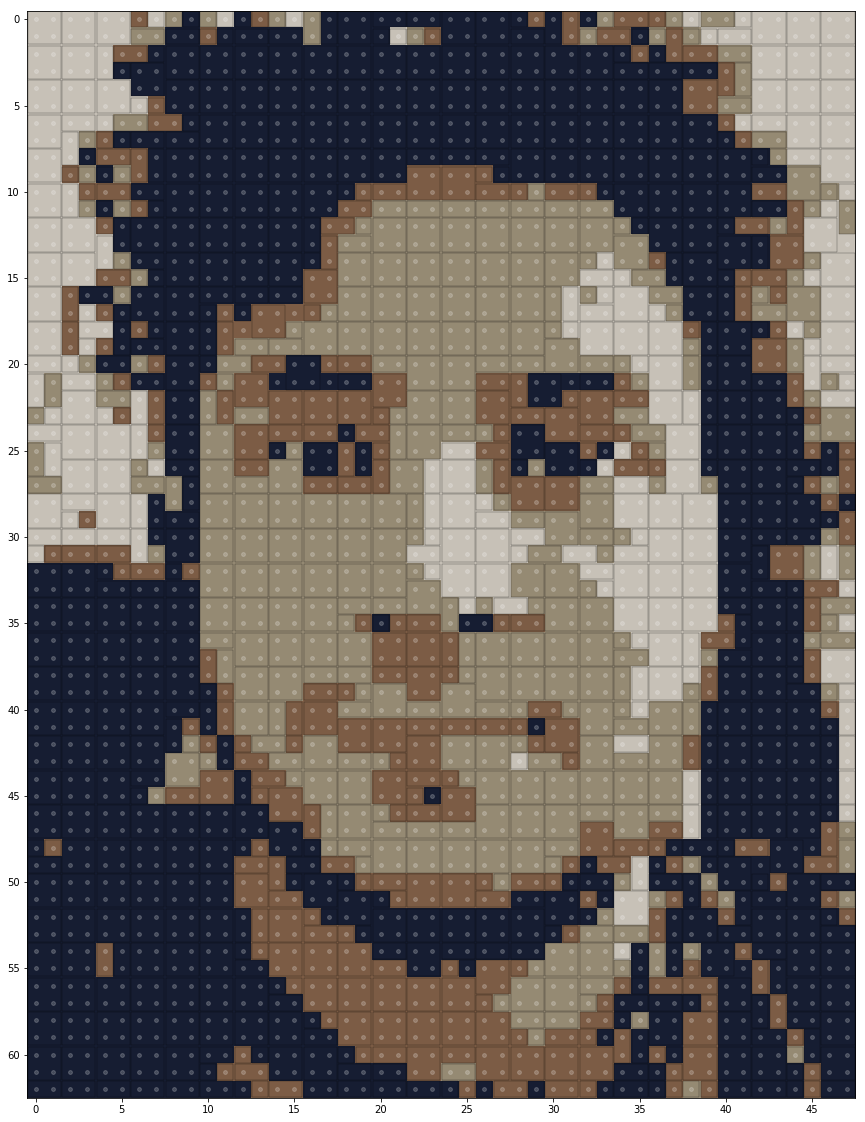

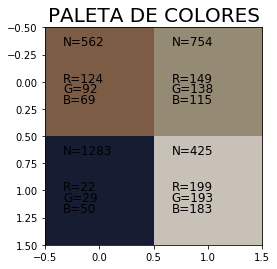

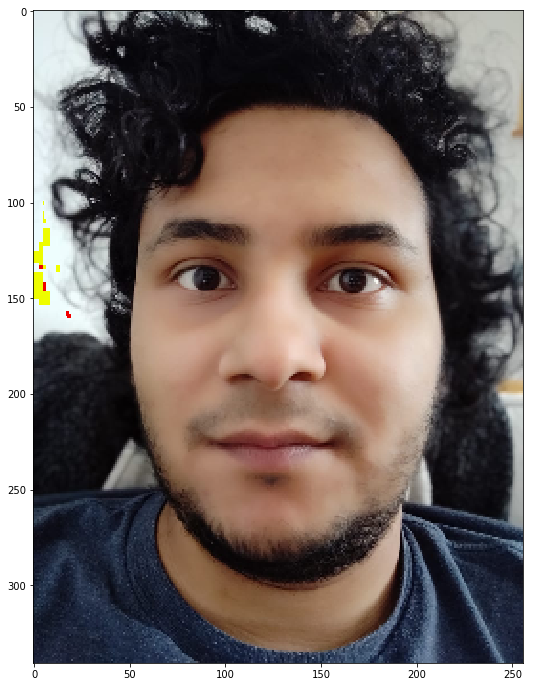

In [24]:
saveProj(img_lego, img_original=img, pathdir='/home/omar/myproj/myface', fig=plt.figure(figsize=(20,20)))

## tests

In [490]:
tab = np.load('/home/omar/myproj/test/table.npy')

In [491]:
tab

array([['161.0_165.0_162.0', '49', '114', '167'],
       ['98.0_71.0_50.0', '31', '111', '202'],
       ['229.0_228.0_222.0', '30', '53', '96'],
       ['13.0_105.0_171.0', '0', '3', '3'],
       ['174.0_122.0_89.0', '62', '103', '146'],
       ['124.0_92.0_69.0', '22', '163', '240'],
       ['149.0_121.0_118.0', '24', '124', '196'],
       ['22.0_29.0_50.0', '68', '69', '93'],
       ['151.0_105.0_91.0', '51', '100', '135'],
       ['156.0_163.0_168.0', '35', '91', '131'],
       ['125.0_187.0_221.0', '0', '9', '17'],
       ['191.0_183.0_177.0', '61', '135', '188'],
       ['total', '433', '1075', '1614']], dtype='<U17')

2x2 	 586
2x1 	 590
1x1 	 647


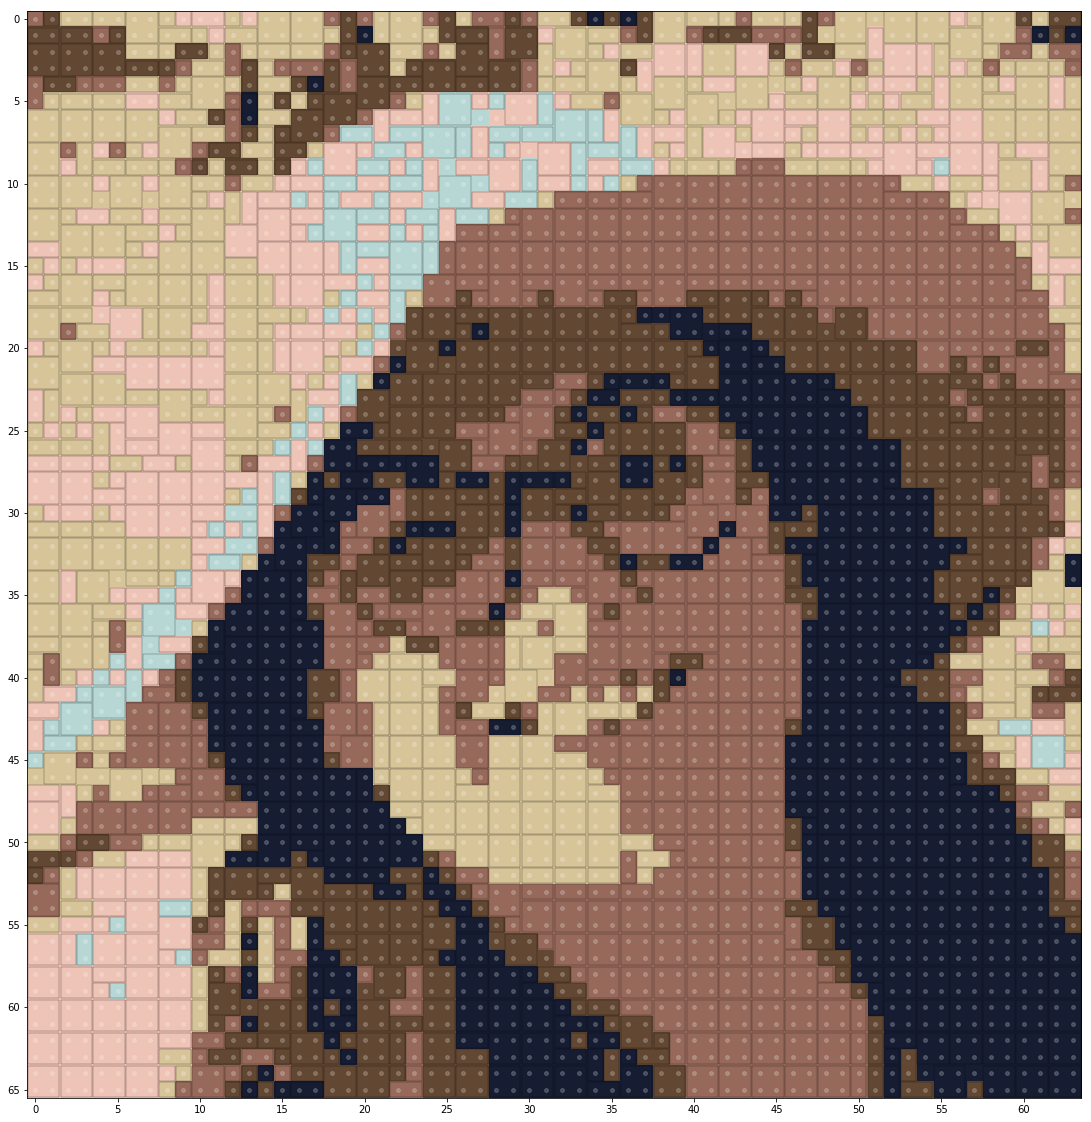

In [76]:
#canvas fig
figcvs = plt.figure(figsize=(20,20))
ax = plt.gca()
plt.imshow(img_lego)
bricksCanvas(img_lego, fig=figcvs, ax=ax, RGB=None, res2x2=res2x2, res2x1=res2x1, res1x1=res1x1)

In [75]:
#fig = plt.figure(figsize=(12,12))
#ax = plt.gca()
#N2x2, N2x1, N1x1 = 

start = time.time()
N2x2, N2x1, N1x1 = makeGiff(img=img_lego, RGB=palette_flat[0], idxs=[res2x2[2], res2x1[2], res1x1[2]], pathdir='/home/omar/myproj/test', fig=figcvs)
end = time.time()
print('Total run time: %f sec' %(end - start))

NameError: name 'palette_flat' is not defined

# DEV ZONE

In [309]:
%matplotlib inline

2x2 	 433
2x1 	 1075
1x1 	 1614


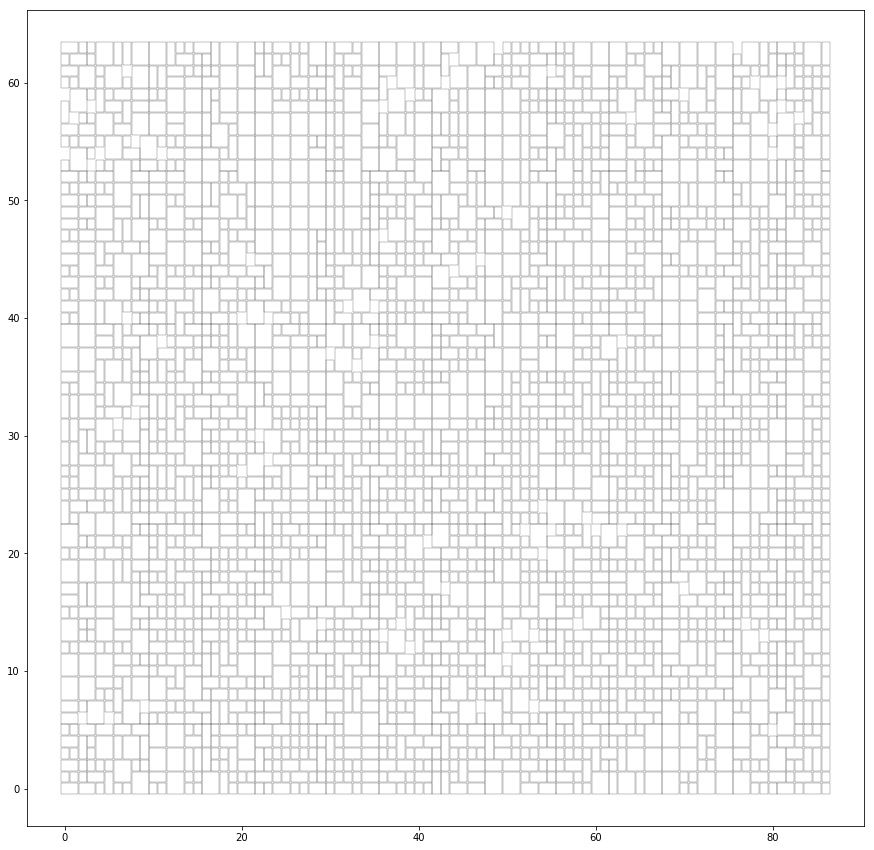

In [401]:
figt = plt.figure(figsize=(15,15))
ax = plt.gca()
#pathdir = '/home/omar/myproj/test'
#plt.imshow(img_lego)
bricksCanvas(img_lego, fig=fig, ax=ax, RGB=None, res2x2=res2x2, res2x1=res2x1, res1x1=res1x1)
#ax = figt.add_subplot(111)
#ax.imshow(img_lego)


In [316]:
figt, ax = plt.subplots(figsize=(15,15))
bricksCanvas(img_lego, fig=figt, ax=ax, RGB=None, res2x2=res2x2, res2x1=res2x1, res1x1=res1x1)
plt.imshow(img_lego)
#figt

AttributeError: 'Figure' object has no attribute 'imshow'

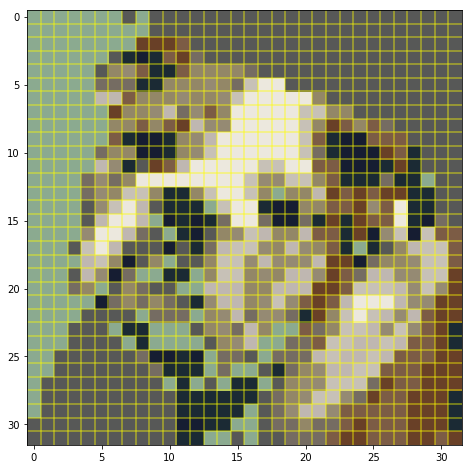

In [1167]:
plt.figure(figsize=(8, 8))
img_sample = selectAColor(img=img_lego, RGB=(39, 70, 44), beta=100)
plt.imshow(img_sample)

bins = np.arange(0.5, lowsize-0.5, 1)
for i in bins:
    plt.axhline(i, c='yellow', alpha=0.5)
    plt.axvline(i, c='yellow', alpha=0.5)
    

1 [147. 135. 103.]


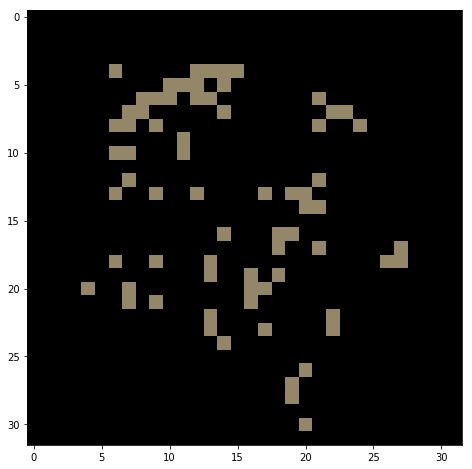

In [261]:
plt.figure(figsize=(8, 8))
img_sample = selectAColor(img=img_lego, RGB=(147, 135, 103))
plt.imshow(img_sample)
#plt.xticks(np.linspace(0, lowsize-1, lowsize))
#plt.yticks(np.linspace(0, lowsize-1, lowsize))
#plt.grid()

1 [39. 70. 44.]
1 [199. 193. 183.]
1 [105.  64.  39.]
1 [236. 232. 222.]
1 [147. 135. 103.]
1 [117. 108.  98.]
1 [22. 29. 50.]
1 [87. 88. 87.]
1 [149. 138. 115.]
1 [27. 42. 52.]
1 [124.  92.  69.]
1 [191. 183. 177.]


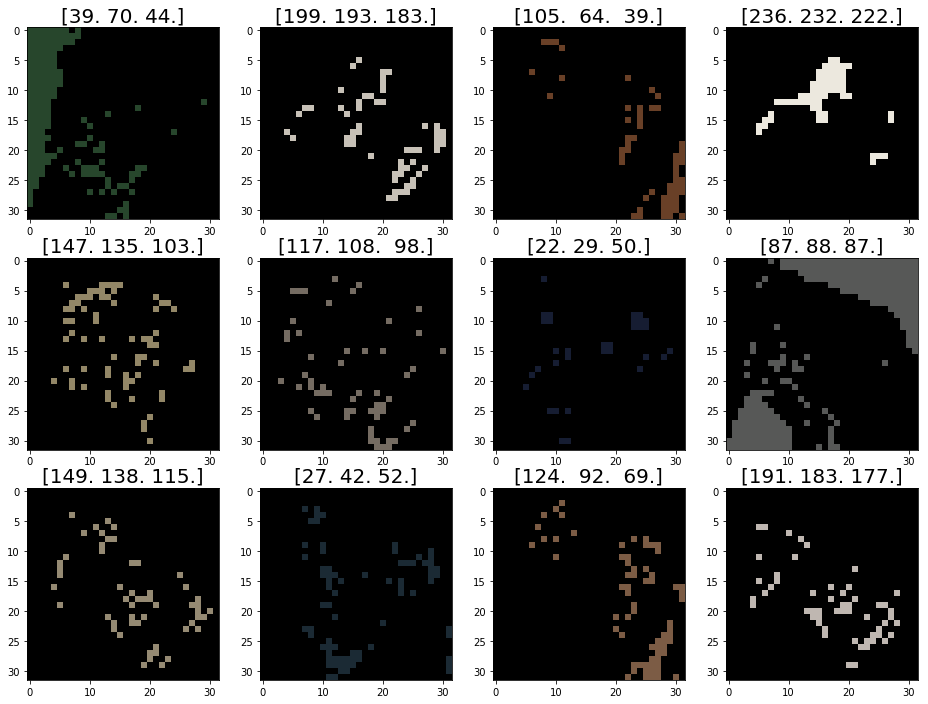

In [248]:
#
c, r = 4, Ncolors/4
plt.figure(figsize=(4*c, 4*r))
img_flat = imgFlat(paletteLego)

for num, key in enumerate(img_flat):
    
    img_sample = selectAColor(img=img_lego, RGB=(key))
    
    plt.subplot(r, c, num+1)
    plt.title(r'%s' %(str(key)), size=20)
    plt.imshow(img_sample)
    #plt.xticks(np.arange(0, lowsize-1))
    #plt.yticks(np.arange(0, lowsize-1))
    #plt.grid()
    

# Everything together

In [230]:
img = imageio.imread('/home/omar/Pictures/bulldog.jpg')
N = 8

h,w = img.shape[0:2]

if (h > 512) or (w > 512): img = resize(img=img, low=256)
print(img.shape)

kmeans_img, indices = kmeans(img=img, N=N)
new_img, indices_new = toBrick(img=img, N=N)
new_img_red = resize(img=new_img, low=32)
kmeans_img2, indices2 = kmeans(img=new_img_red, N=N)
new_img_red2, indices_new2 = toBrick(img=new_img_red, N=N)

/home/omar/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/omar/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(256, 256, 3)
(65536, 3)
(1024, 3)


/home/omar/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/omar/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

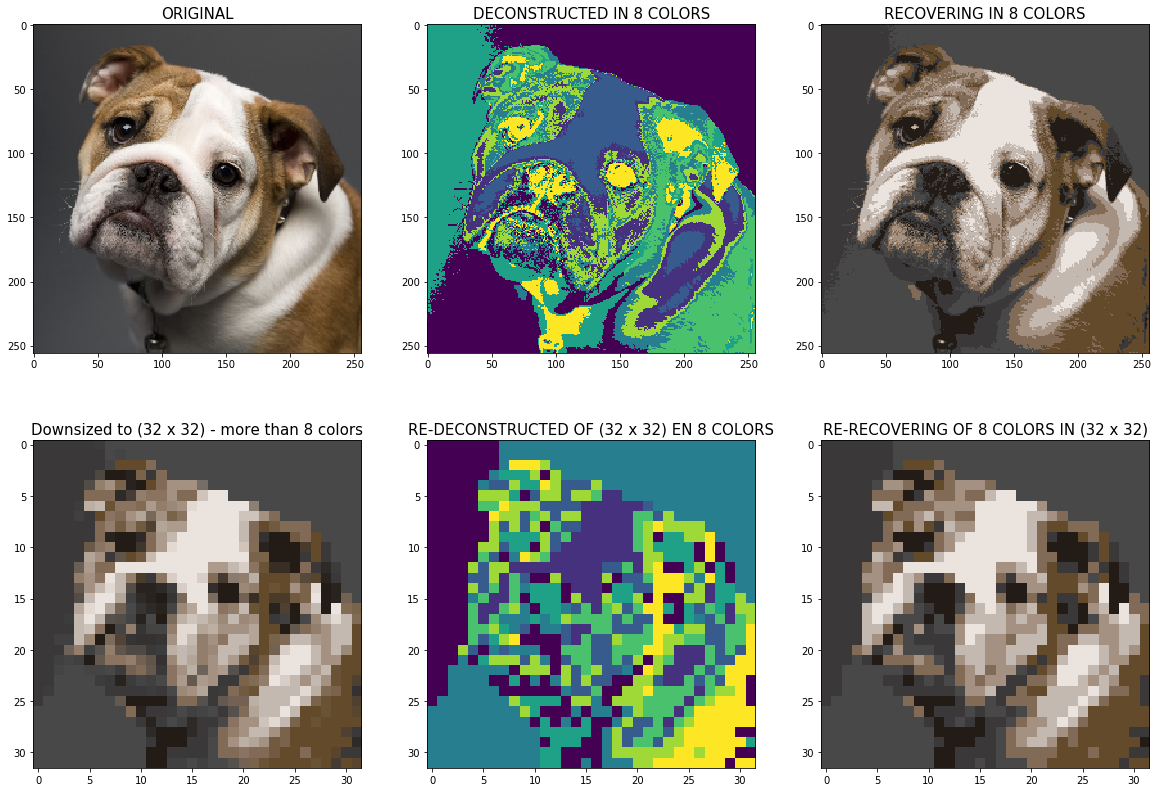

In [227]:
#
fig = plt.figure(figsize=(20, 14))
Nlist = len(list(set(indices)))

plt.subplot(2, 3, 1)
plt.title(r'ORIGINAL', size=15)
plt.imshow(img)

plt.subplot(2, 3, 2)
plt.title(r'DECONSTRUCTED IN %i COLORS' %(Nlist), size=15)
plt.imshow(kmeans_img)

plt.subplot(2, 3, 3)
plt.title(r'RECOVERING IN %i COLORS' %(Nlist), size=15)
plt.imshow(new_img)

plt.subplot(2, 3, 4)
plt.title(r'Downsized to (%i x %i) - more than %i colors' %(new_img_red.shape[0], new_img_red.shape[1], Nlist), size=15)
plt.imshow(new_img_red)

plt.subplot(2, 3, 5)
plt.title(r'RE-DECONSTRUCTED OF (%i x %i) EN %i COLORS' %(new_img_red.shape[0], new_img_red.shape[1], Nlist), size=15)
plt.imshow(kmeans_img2)

plt.subplot(2, 3, 6)
plt.title(r'RE-RECOVERING OF %i COLORS IN (%i x %i)' %(Nlist, new_img_red.shape[0], new_img_red.shape[1]), size=15)
plt.imshow(new_img_red2)

fig.savefig('reconstruccion_test.jpeg', bbox_inches = 'tight', pad_inches = 0)

# DEV ZONE...

In [116]:
for i in range(len(imgflat)):
    R, G, B = imgflat[i]
    RL, GL, BL = legoColors[indices[i,0]]
    dist = np.sqrt((np.abs(R-RL))**2 + (np.abs(G-GL))**2 + (np.abs(B-BL))**2)
    
    print('original:', imgflat[i], '\t', '==>', '\t', 'inLego',legoColors[indices[i,0]])

original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [58. 56. 57.] 	 ==> 	 inLego [39. 70. 44.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88. 87.]
original: [72. 72. 73.] 	 ==> 	 inLego [87. 88

Think about what these indices actually mean before moving on. 